In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
boston = load_boston()

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

input_x = pd.DataFrame(boston['data'], columns=boston['feature_names'])
input_y = boston['target']
mms = MinMaxScaler().fit(input_x)
train_x, test_x, train_y, test_y = train_test_split(mms.transform(input_x), input_y, test_size=0.2, random_state=0)

def get_score_KR(x):
    alpha, gamma = x
    predictor = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
    return cross_val_score(predictor, train_x, train_y, cv=5).mean()
def get_score_KR_log(x):
    print(x)
    return get_score_KR((10**x[0][0], 10**x[0][1]))

[[-3.16895815 -1.4308492 ]]
[[-2.6060547   1.61974507]]
[[-1.63133805 -2.99148017]]
[[-0.88376204 -1.00872336]]
[[ 1.38849269 -3.39137003]]


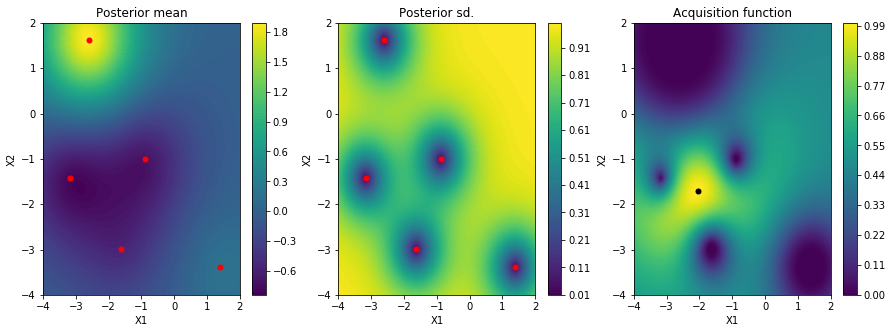

In [3]:
import GPyOpt
bounds = [{'name': 'log alpha', 'type': 'continuous', 'domain': (-4,2)},
         {'name': 'log gamma', 'type': 'continuous', 'domain': (-4,2)}]
bo = GPyOpt.methods.bayesian_optimization.BayesianOptimization(
    f=get_score_KR_log, domain=bounds, model_type='GP', acquisition_type='EI', initial_design_numdata=5, maximize=True)
bo.run_optimization()
bo.plot_acquisition()

In [4]:
KernelRidge(kernel='rbf').fit(train_x, train_y).score(test_x, test_y)

0.4802674032751879

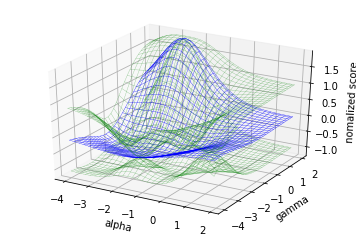

In [5]:
def plot_predict_3d(bo, x_lin = np.arange(-4, 2, 0.1), y_lin = np.arange(-4, 2, 0.1)):
    x, y = np.meshgrid(x_lin, y_lin)
    z_mean, z_std = bo.model.model.predict(np.stack([x.flatten(),y.flatten()]).T)
    z_mean = z_mean.reshape(x_lin.size, y_lin.size)
    z_std = z_std.reshape(x_lin.size, y_lin.size)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    #ax.set_zlim(0.8,0.9)
    ax.set_xlabel('alpha')
    ax.set_ylabel('gamma')
    ax.set_zlabel('nomalized score')

    ax.plot_wireframe(x, y, z_mean, color='blue',linewidth=0.3)
    ax.plot_wireframe(x, y, z_mean+z_std, color='green',linewidth=0.3, alpha=0.5)
    ax.plot_wireframe(x, y, z_mean-z_std, color='green',linewidth=0.3, alpha=0.5)
    
    plt.show()
plot_predict_3d(bo)

[[-2.05715701 -1.70298333]]


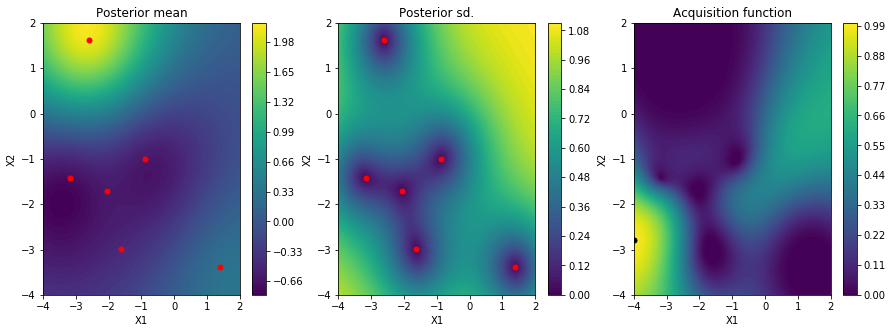

In [6]:
bo.run_optimization(max_iter=1)
bo.plot_acquisition()

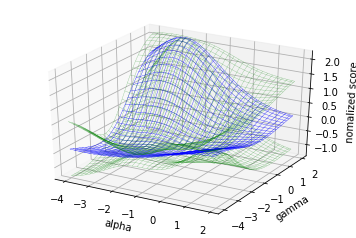

In [7]:
plot_predict_3d(bo)

[[-4.         -2.78747364]]


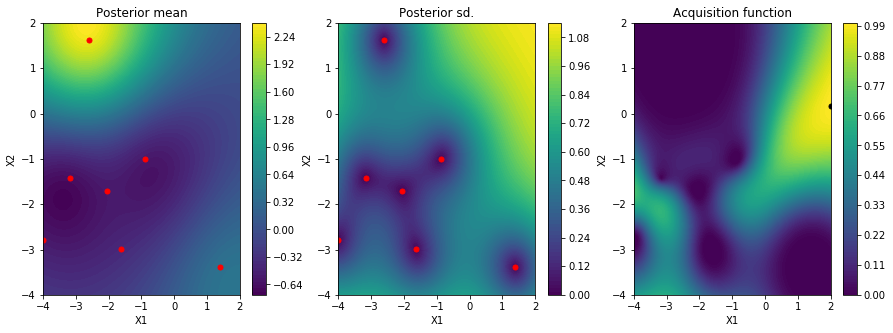

[[2.         0.16800167]]


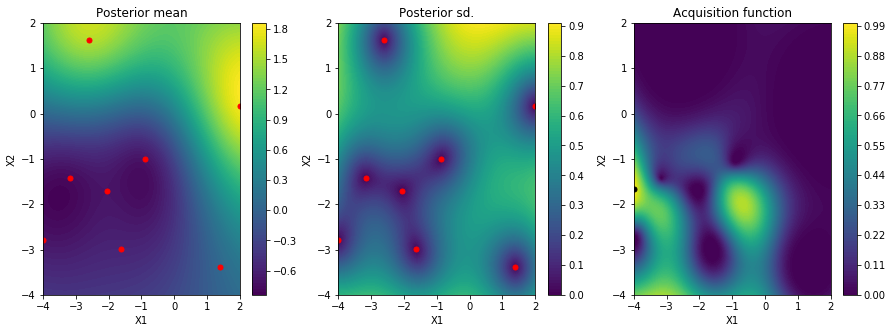

[[-4.         -1.66734649]]


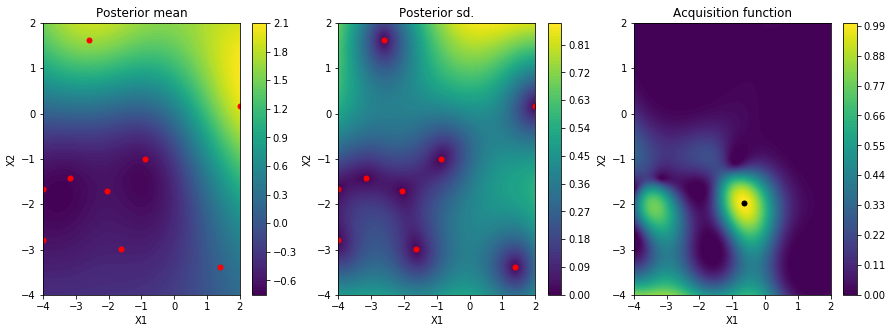

[[-0.64151613 -1.97514829]]


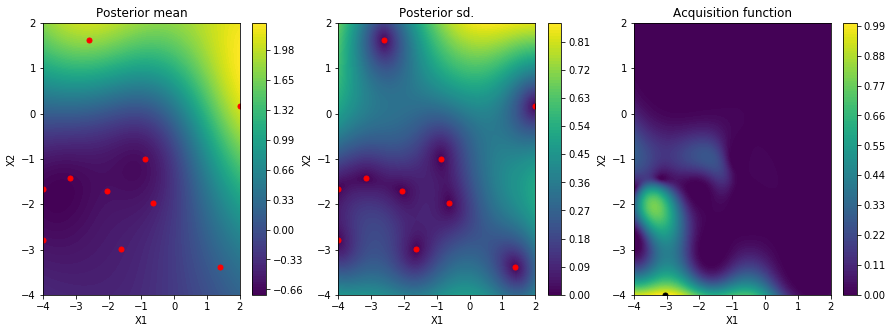

[[-3.05510085 -4.        ]]


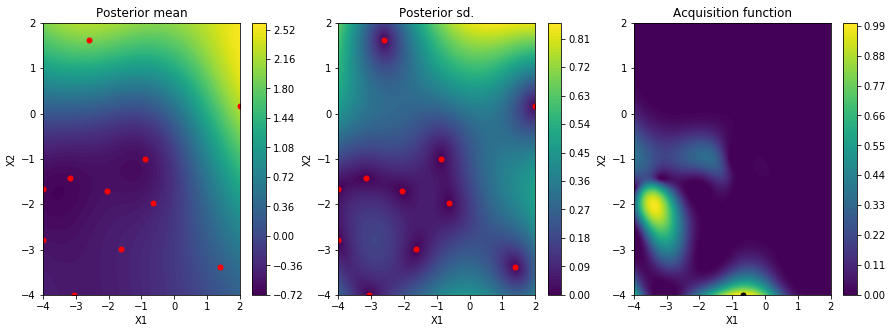

[[-0.67356084 -4.        ]]


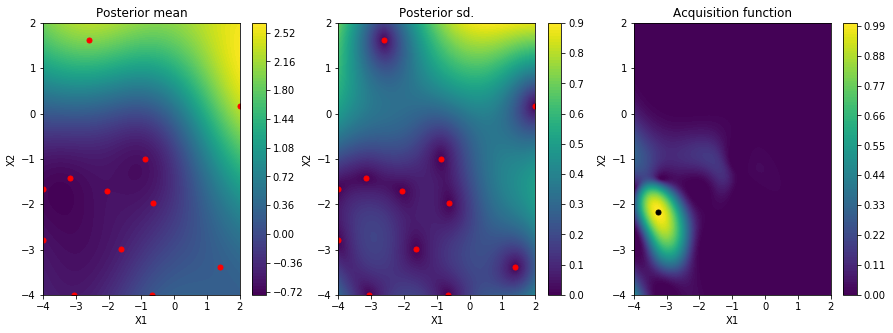

[[-3.25726847 -2.16568013]]


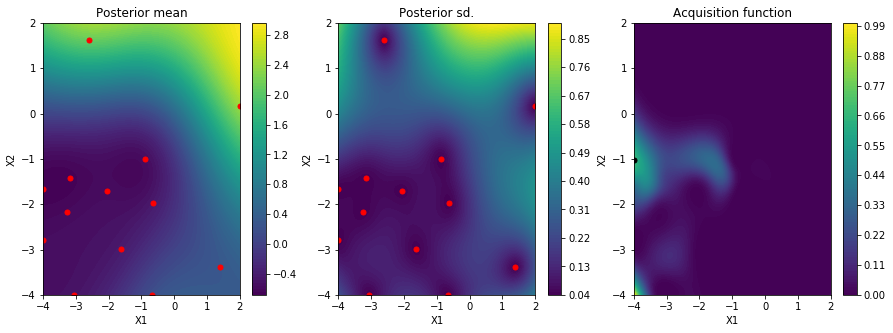

[[-4. -4.]]


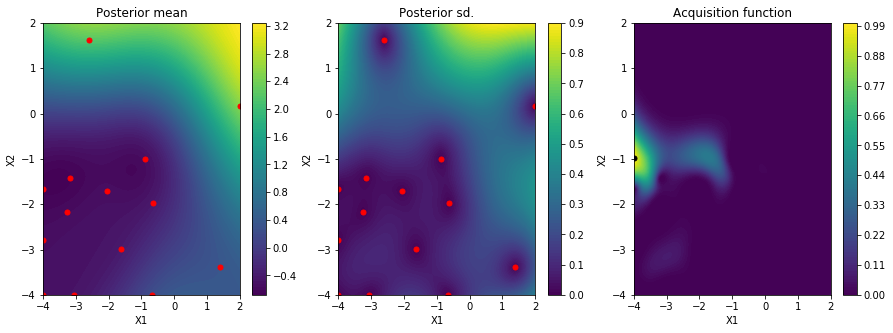

[[-4.         -0.98741862]]


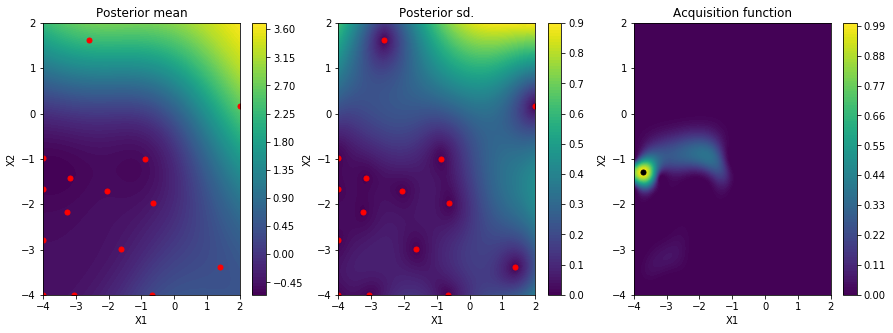

[[-3.71488714 -1.29660075]]


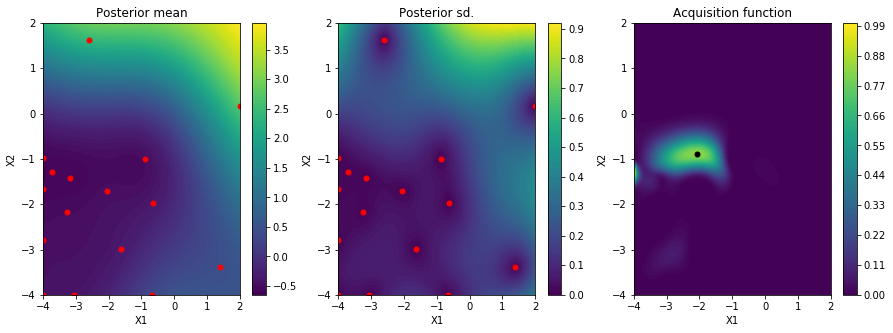

In [8]:
for _ in range(10):
    bo.run_optimization(max_iter=1)
    bo.plot_acquisition()

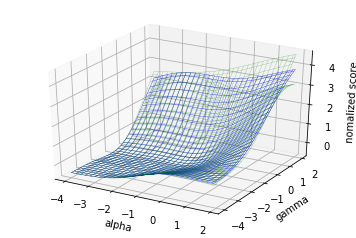

In [9]:
plot_predict_3d(bo)

[[-2.07534134 -0.88926944]]
[[-2.77884098 -1.02197761]]
[[-1.56872027 -1.06962586]]
[[-4.         -1.30834076]]
[[-3.262385   -1.05904154]]
[[-2.4687103  -1.03900324]]
[[-2.49091111 -0.74097739]]
[[-4.        -0.3495899]]
[[-1.69452751 -0.53734797]]
[[-2.0676785 -0.5876816]]
[[-3.50184336 -0.70459654]]
[[-3.00324771 -0.66789103]]
[[ 0.72653327 -1.7768321 ]]
[[-2.65627871 -0.48508578]]
[[-3.0277169  -0.36104535]]
[[-1.0092566  -0.21859019]]
[[-1.23023134 -0.43547571]]
[[-1.58585672 -0.15475409]]
[[-1.97439296 -0.25720405]]
[[-2.33069948 -0.30056553]]
[[ 2. -4.]]
[[-2.82443305 -3.17126395]]
[[-0.27371932 -0.43927814]]
[[-0.34951858  0.2717806 ]]
[[-3.67857876 -1.67920166]]
[[-3.69358027 -3.59167396]]
[[-2.26283419 -0.0272067 ]]
[[-2.58422514 -0.20037405]]
[[-1.81445651  0.05039105]]
[[-1.24094666  0.29208489]]
[[0.88522988 1.94325303]]
[[ 1.98418774 -2.14477408]]
[[-2.13762804 -3.87035063]]
[[-2.68510626 -1.50741554]]
[[-3.98950616 -2.033296  ]]
[[ 0.56162265 -0.43478766]]
[[-1.36999766 

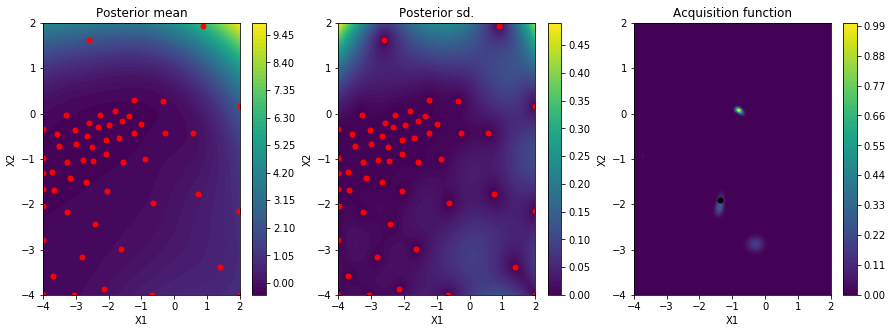

In [10]:
bo.run_optimization(max_iter=40)
bo.plot_acquisition()

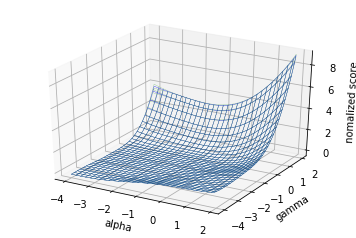

In [11]:
plot_predict_3d(bo)

In [12]:
bo.x_opt, bo.fx_opt

(array([-1.97439296, -0.25720405]), -0.8913999192236917)

In [13]:
predictor_opt = KernelRidge(kernel='rbf', alpha=10**bo.x_opt[0], gamma=10**bo.x_opt[1])
predictor_opt.fit(train_x, train_y)

from sklearn.metrics import r2_score
predictor_opt.score(train_x ,train_y), predictor_opt.score(test_x ,test_y)

(0.9651908615856974, 0.8114250068143878)

In [14]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha':[i*10**j for j in [-4, -3, -2, -1, 0, 1] for i in [1, 2, 4, 8]], 
              'gamma':[i*10**j for j in [-4, -3, -2, -1, 0, 1] for i in [1, 2, 4, 8]]}
gcv = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5)

In [15]:
%%time
gcv.fit(train_x, train_y)

Wall time: 19.7 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.0002, 0.0004, 0.0008, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 10, 20, 40, 80], 'gamma': [0.0001, 0.0002, 0.0004, 0.0008, 0.001, 0.002, 0.004, 0.008, 0.01, 0.02, 0.04, 0.08, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 10, 20, 40, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
bes = gcv.best_estimator_
bes.fit(train_x, train_y)
bes.score(train_x, train_y), bes.score(test_x, test_y)

(0.9671912182630793, 0.8097198949264954)

In [17]:
np.log10(gcv.best_params_["alpha"]),np.log10(gcv.best_params_["gamma"]),

(-2.3979400086720375, -0.3979400086720376)

In [19]:
xx, yy = np.meshgrid(np.log10([i*10**j for j in [-4, -3, -2, -1, 0, 1] for i in [1, 2, 4, 8]]),
                     np.log10([i*10**j for j in [-4, -3, -2, -1, 0, 1] for i in [1, 2, 4, 8]]))

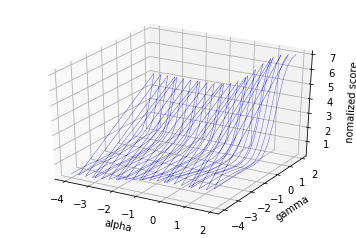

In [20]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_zlim(0.8,0.9)
ax.set_xlabel('alpha')
ax.set_ylabel('gamma')
ax.set_zlabel('nomalized score')

ax.plot_wireframe(np.log10(np.array(gcv.cv_results_["param_alpha"].data.astype('float'))),
                  np.log10(np.array(gcv.cv_results_["param_gamma"].data.astype('float'))),
                  1-gcv.cv_results_["mean_test_score"].reshape(1,-1), color='blue',linewidth=0.3)

plt.show()

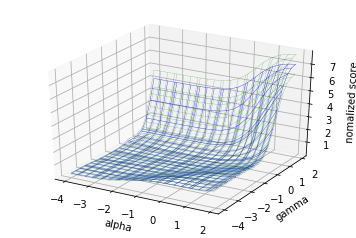

In [21]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_zlim(0.8,0.9)
ax.set_xlabel('alpha')
ax.set_ylabel('gamma')
ax.set_zlabel('nomalized score')

ax.plot_wireframe(xx, yy,
                  1-gcv.cv_results_["mean_test_score"].reshape(24,-1).T, color='blue',linewidth=0.3)
ax.plot_wireframe(xx, yy,
                  1-gcv.cv_results_["mean_test_score"].reshape(24,-1).T+gcv.cv_results_["std_test_score"].reshape(24,-1).T,
                  color='green',linewidth=0.3, alpha=0.5)
ax.plot_wireframe(xx, yy,
                  1-gcv.cv_results_["mean_test_score"].reshape(24,-1).T-gcv.cv_results_["std_test_score"].reshape(24,-1).T,
                  color='green',linewidth=0.3, alpha=0.5)

plt.show()